In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Function definitions:

In [2]:
def string_to_tuple(input):
    output = input.strip('()')
    return  pd.Series(map(float, output.split(', ')))

def expand_col(df, col):
    if type(df.loc[0, col]) == str:
        col_expanded = df[col].apply(string_to_tuple)
    col_expanded.columns = [f'{col}_{i}' for i in range(len(col_expanded.columns))]
    df_new = pd.concat([df, col_expanded], axis=1)
    return df_new.drop(col, axis=1)

def index_unique_vals(df, col):
    return dict(zip(df[col].unique(), np.arange(df[col].nunique())))

In [11]:
def plot_grid(data, x, y, var_rows, var_cols, var_colors, plot_type='line', x_scale=None, sharex=True, sharey=False):
    index_cols, index_rows = index_unique_vals(data, var_cols), index_unique_vals(data, var_rows)
    n_cols, n_rows = len(index_cols), len(index_rows)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 4*n_rows), sharex=sharex, sharey=sharey)
    for group_params, data_subplot in data.groupby([var_rows, var_cols]):
        row, col = index_rows[group_params[0]], index_cols[group_params[1]]
        if n_rows == 1:
            ax = axes[col]
        elif n_cols == 1:
            ax = axes[row]
        else:
            ax = axes[row, col]
        plot = ax.scatter if plot_type == 'scatter' else ax.plot
        for label, data_line in data_subplot.groupby(var_colors):
            data_line.sort_values(by=x, inplace=True)
            plot(data_line[x], data_line[y], label=label)
            
        if col == 0:
            if n_rows > 1:
                ax.set_ylabel(f'{var_rows}: {group_params[0]}', size='large', fontweight='bold')
            else:
                ax.set_ylabel(y)
        if row == n_rows - 1:
            ax.set_xlabel(x)
            if x_scale and x_scale != 'linear':
                ax.set_xscale(x_scale)
        if row == 0:
            ax.set_title(f'{var_cols}: {group_params[1]}', size='large', fontweight='bold')
        
        ax.grid()
        ax.legend()
    fig.tight_layout()
    return fig

In [ ]:
def lm(x, y):
    coefs = np.polyfit(x,y,1)
    poly1d_fn = np.poly1d(coefs) 
return poly1d_fn

# Plots for first experiment

In [38]:
dfs = pd.read_csv('gridsearch_results.csv').dropna()
df_expanded = expand_col(dfs, 'hidden_dims')
df_latent_dim = df_expanded[df_expanded['hidden_dims_0'] == 1.0]
df_first_dim = df_expanded[(df_expanded['hidden_dims_1'] == 0.1) & (df_expanded['hidden_dims_0'] != 1.0)]

In [39]:
df_avg = df_expanded.groupby(['hidden_dims_0', 'hidden_dims_1', 'dropout', 'n_layers', 'clf']).agg('mean')
df_avg.reset_index(inplace=True)
df_avg_latent_dim = df_avg[df_avg['hidden_dims_0'] == 1.0]
df_avg_first_dim = df_avg[(df_avg['hidden_dims_1'] == 0.1) & (df_avg['hidden_dims_0'] != 1.0)]

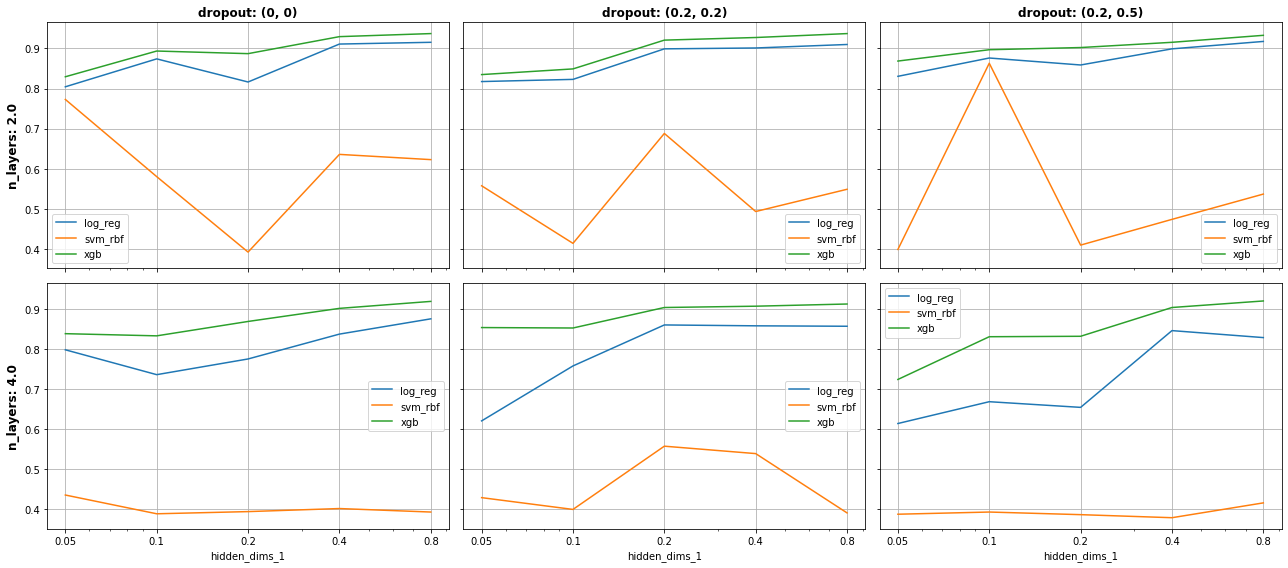

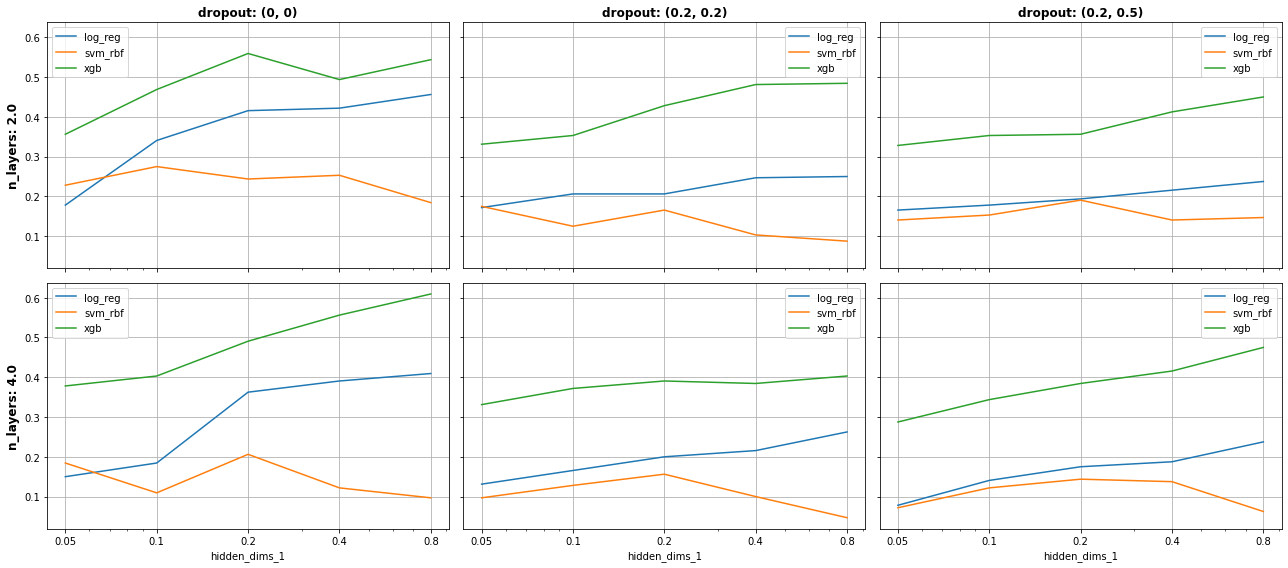

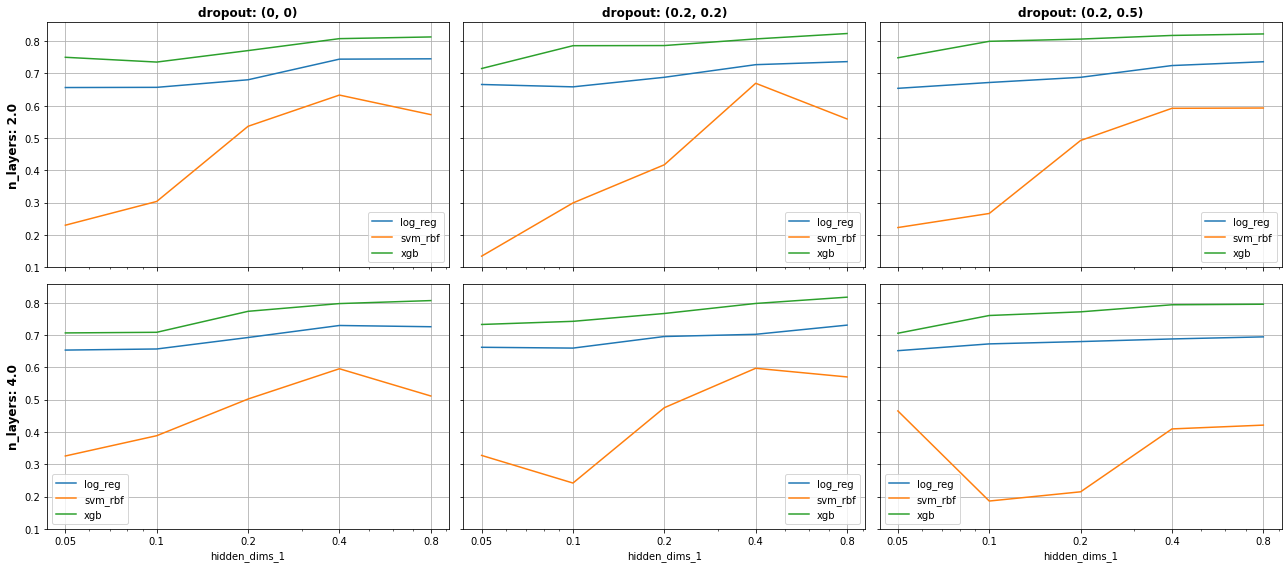

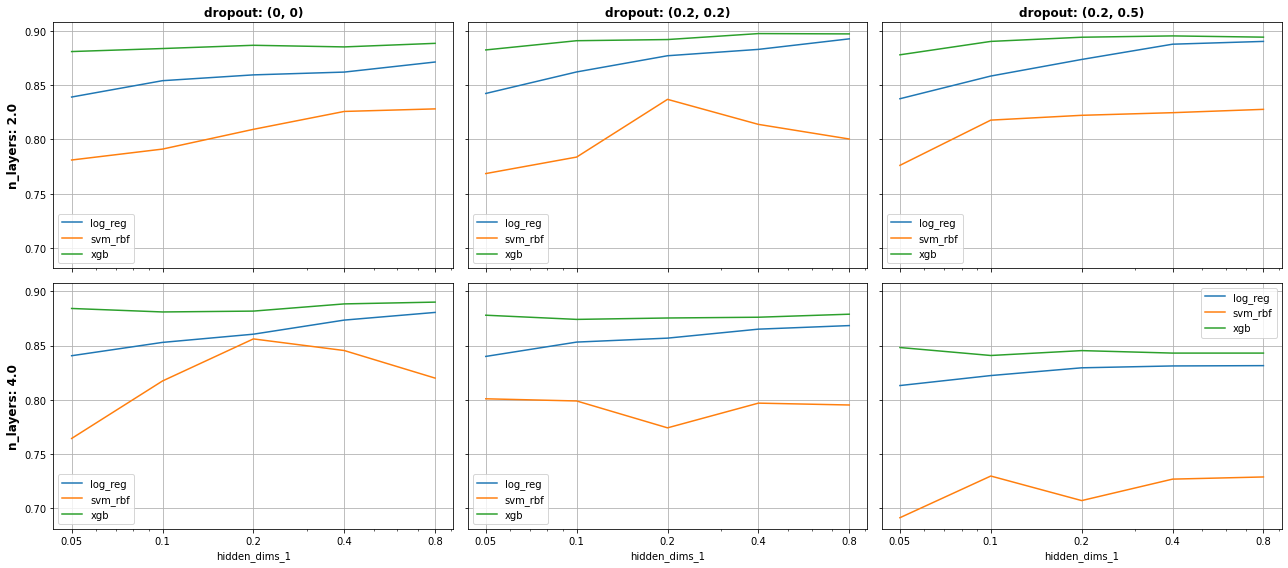

In [41]:
for dataset_id, data in df_latent_dim.groupby('dataset_id'):
    fig = plot_grid(data=data, x='hidden_dims_1', y='mean_test_score', var_rows='n_layers', var_cols='dropout', var_colors='clf', x_scale='log')
    plt.savefig(f'plots/accuracy_vs_latent_dim_{dataset_id}.svg')

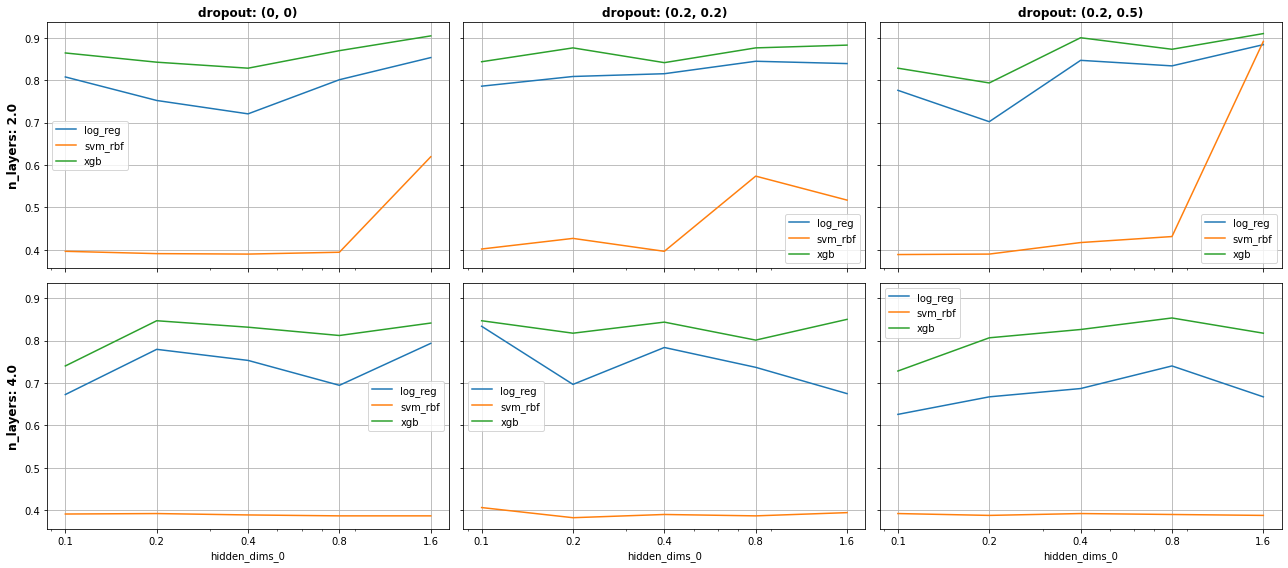

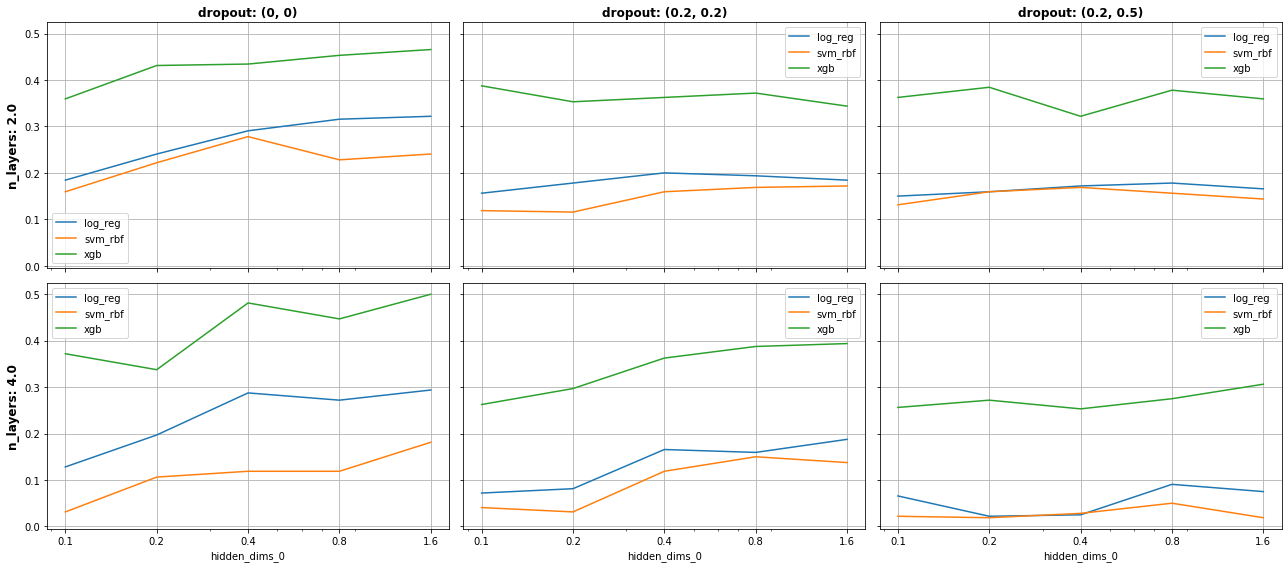

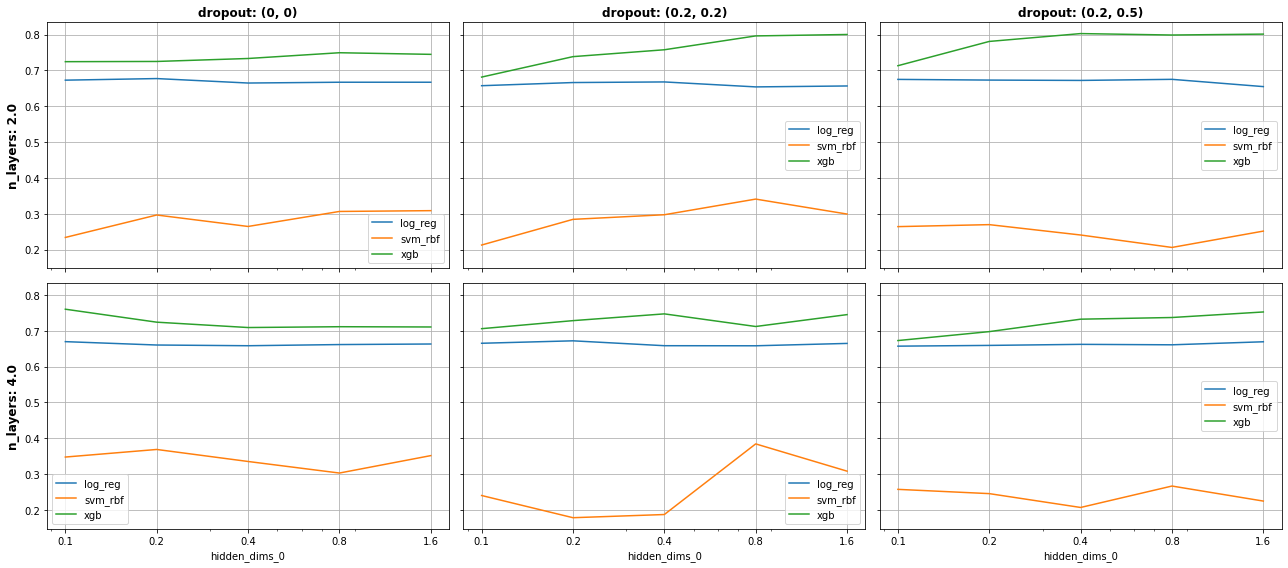

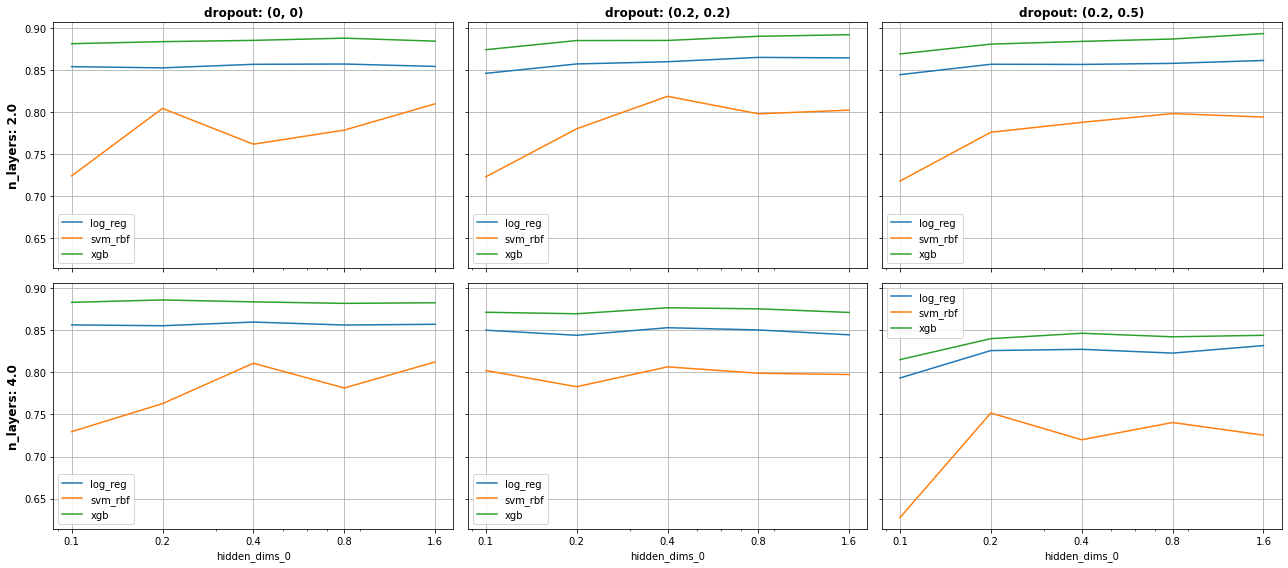

In [42]:
for dataset_id, data in df_first_dim.groupby('dataset_id'):
    fig = plot_grid(data=data, x='hidden_dims_0', y='mean_test_score', var_rows='n_layers', var_cols='dropout', var_colors='clf', x_scale='log')
    plt.savefig(f'plots/accuracy_vs_first_dim_{dataset_id}.svg')

In [ ]:
fig = plot_grid(data=df_avg_latent_dim, x='hidden_dims_1', y='mean_test_score', var_rows='n_layers', var_cols='dropout', var_colors='clf', x_scale='log')
plt.savefig(f'./plots/avg_accuracy_vs_latent_dim.svg')

In [ ]:
fig = plot_grid(data=df_avg_first_dim, x='hidden_dims_0', y='mean_test_score', var_rows='n_layers', var_cols='dropout', var_colors='clf', x_scale='log')
plt.savefig(f'plots/avg_accuracy_vs_first_dim.svg')

# Plots for second experiment

In [5]:
dfs = pd.read_csv('gridsearchcv_results_005.csv')

## Plot classification accuracy 

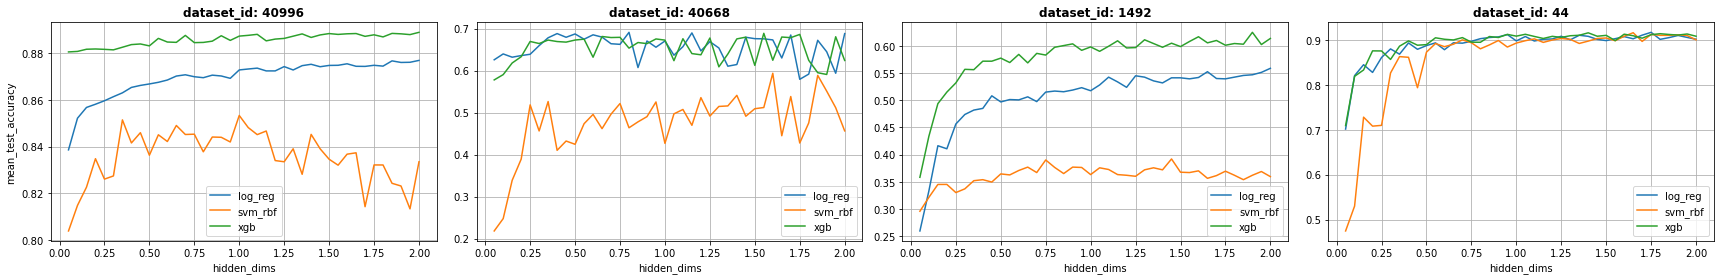

In [12]:
fig = plot_grid(data=dfs, x='hidden_dims', y='mean_test_accuracy', var_rows='n_layers', var_cols='dataset_id', var_colors='clf')
plt.savefig(f'plots/accuracy_vs_latent_dim_all_datasets.svg')

## Plot training times

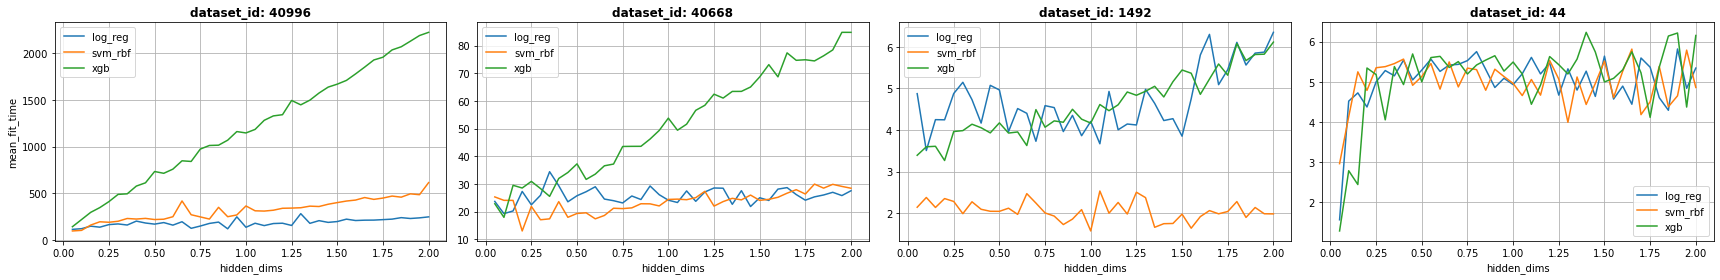

In [13]:
fig = plot_grid(data=dfs, x='hidden_dims', y='mean_fit_time', var_rows='n_layers', var_cols='dataset_id', var_colors='clf')
plt.savefig(f'plots/training_time_vs_latent_dim_all_datasets.svg')

## Plot inference times

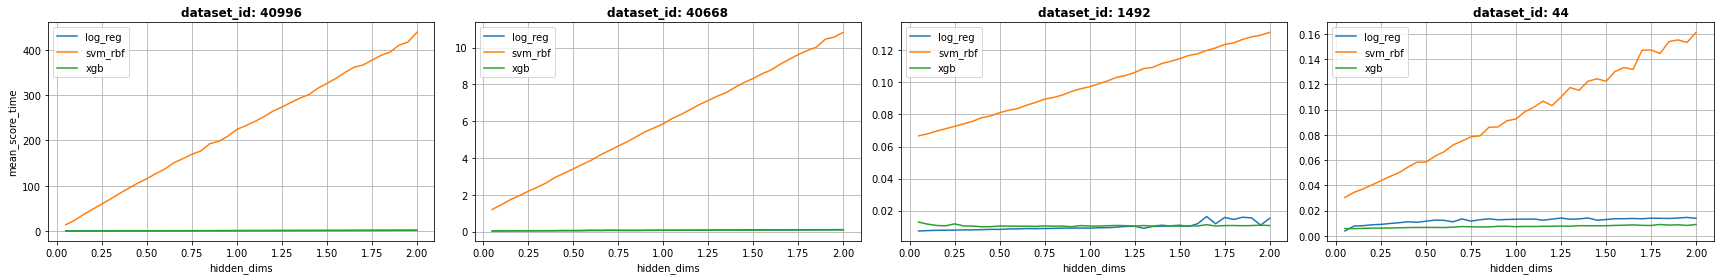

In [14]:
fig = plot_grid(data=dfs, x='hidden_dims', y='mean_score_time', var_rows='n_layers', var_cols='dataset_id', var_colors='clf')
plt.savefig(f'plots/training_time_vs_latent_dim_all_datasets.svg')

# Plot reconstruction error

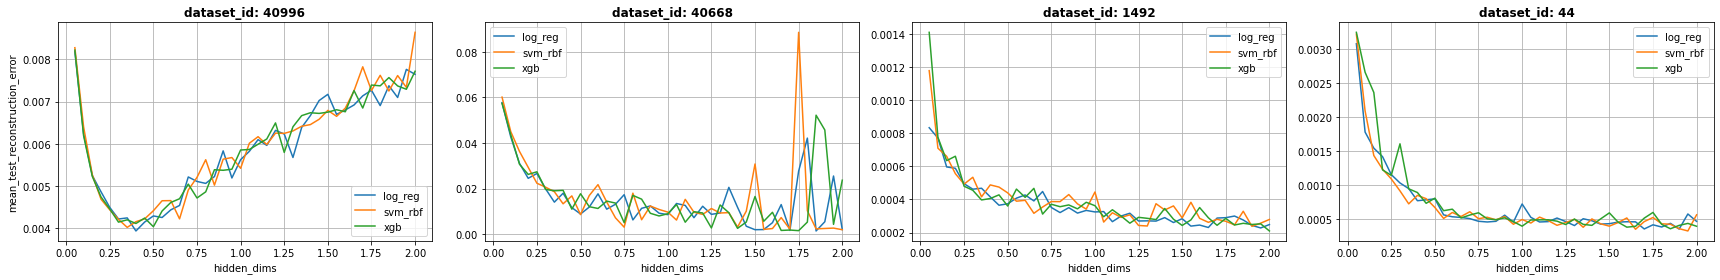

In [15]:
fig = plot_grid(data=dfs, x='hidden_dims', y='mean_test_reconstruction_error', var_rows='n_layers', var_cols='dataset_id', var_colors='clf')
plt.savefig(f'plots/reconstruction_error_vs_latent_dim_all_datasets.svg')

## Scatterplot: Classification Accuracy vs. Reconstruction Error

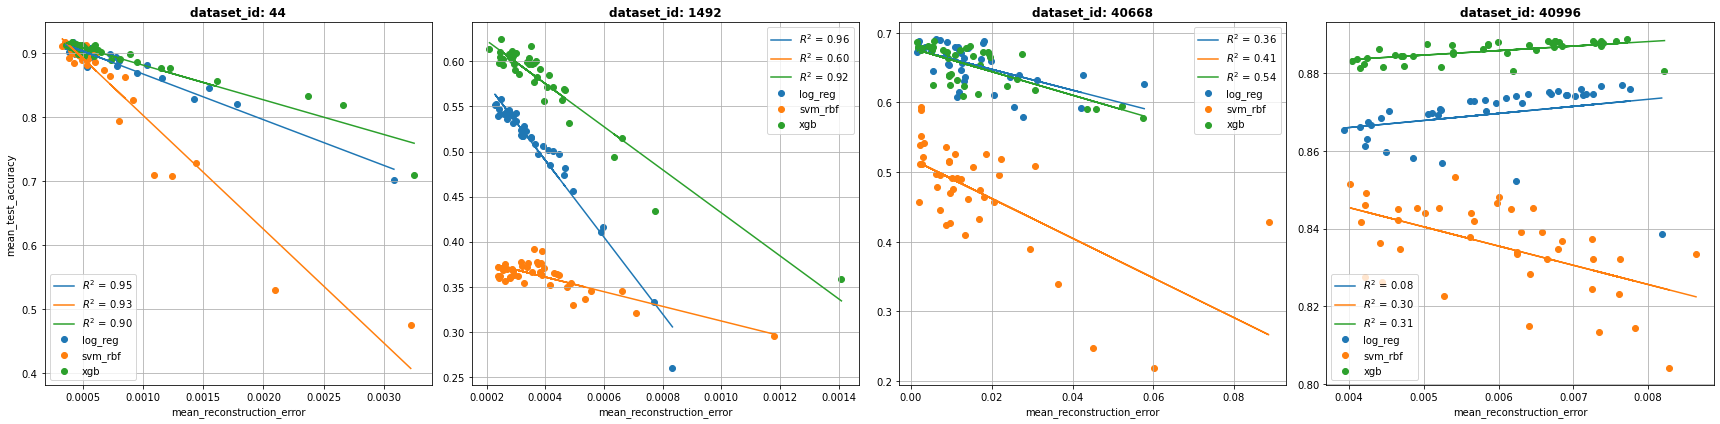

In [162]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import ttest_ind
fig, axes = plt.subplots(1,4, figsize=(24, 6))
reg_stats = []
for idx, (dataset_id, df_dataset) in enumerate(dfs.groupby('dataset_id')):
    ax = axes[idx]
    for clf, df_clf in df_dataset.groupby('clf'):
        x, y = df_clf['mean_test_reconstruction_error'], df_clf['mean_test_accuracy']
        x_expanded = np.expand_dims(x, -1)
        reg = LinearRegression()
        reg.fit(x_expanded, y)
        r2 = r2_score(y, reg.predict(x_expanded))
        r2_str = '{0:.2f}'.format(r2)
        ax.scatter(x, y, label=clf)
        ax.plot(x, reg.predict(x_expanded), label= r'$R^2$ = {}'.format(r2_str))
        
    ax.set_title(f'dataset_id: {dataset_id}', size='large', fontweight='bold')
    ax.set_xlabel('mean_reconstruction_error')
    
    ax.grid()
    ax.legend()

axes[0].set_ylabel('mean_test_accuracy')
fig.tight_layout()
plt.savefig(f'plots/classification_accuracy_vs_reconstruction_error_datasets.svg')

In [165]:
import statsmodels.api as sm
df_encoded = pd.get_dummies(dfs, columns=['clf'], prefix='', prefix_sep='', drop_first=True)
regressors = ['mean_test_reconstruction_error', 'hidden_dims']
x, y = dfs[regressors], dfs['mean_test_accuracy']
x = sm.add_constant(x)
lm = sm.OLS(y, x)
results = lm.fit()
summary = results.summary()
with open(f'ols_classification_vs_reconstruction_and_latent_dim.txt', 'w') as file:
    file.write(summary.as_latex())

# Plots of common activation functions

In [5]:
x = np.linspace(-8, 8, 200)
sigmoid = lambda x: 1/(1+np.exp(-x))
tanh = lambda x: np.tanh(x)
relu = lambda x: np.where(x>0, x, 0)
scale, alpha = 1.05070098, 1.67326324 #Constants used by Tensorflow
selu = lambda x: np.where(x>0, scale * x, scale * alpha * (np.exp(x)-1))

In [27]:
for name, f in (('sigmoid', sigmoid), ('tanh', tanh), ('relu', relu), ('selu', selu)):
    fig, ax = plt.subplots()
 
    ax.axvline(0, c='black')
    ax.axhline(0, c='black')
    ax.set_xlabel('Weighted Inputs')
    ax.set_ylabel('Output')
    ax.plot(x, f(x))
    ax.grid()
    
    plt.savefig(f'plots/{name}.svg')
    plt.close(fig)

# Plot loss-functions

In [30]:
binary_crossentropy = lambda y_true, y_pred: -(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
mean_absolute_error = lambda y_true, y_pred: np.abs(y_true - y_pred)
mean_squared_error = lambda y_true, y_pred: (y_true - y_pred) ** 2
kld = lambda y_true, y_pred: y_true * np.log(y_true/y_pred) + (1 - y_true) * np.log((1-y_true)/(1-y_pred))

n_points = 1000
y = 0.25
y_true = np.repeat(y, n_points)
y_pred = np.linspace(0, 1, n_points)
for name, f in (('binary_crossentropy', binary_crossentropy), ('mae', mean_absolute_error), ('mse', mean_squared_error), ('kld', kld)):
    fig, ax = plt.subplots()
    ax.plot(y_pred, f(y_true, y_pred))
    ax.set_xlabel('Average Activity')
    ax.set_ylabel('Loss')
    ax.grid()
    ax.axvline(y, c='grey', linestyle='--')
    plt.xticks(np.arange(0, 1.25, 0.25))
    plt.savefig(f'plots/{name}.svg')
    plt.close(fig)

/home/lucas/anaconda3/envs/plotting/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/home/lucas/anaconda3/envs/plotting/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
